Single spillover (non-recurrent) branching process (infinite population), plots beta, gamma, and number infected over time.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#class representing one simulation.

class Sim:
    def __init__(self, outcome, times, betas, gammas, I):
        
        #0 if extinction, 1 if outbreak.
        self.outcome = outcome 
        
        #the number of events in the simulation
        self.length = len(times)
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.I = I #the number of infecteds, inclusive of the new event

In [221]:
#############################################################
# version of sim which 
#    1. is implemented in "time order" instead of "generation order"
#        (this makes it slower to run, but it's needed in order to make accurate plots)
#    2. returns an element of the class Sim.
#############################################################

def sim_class(beta_0, gamma_0, mu_1=0, mu_2=0):
    
    outbreak_thresh = 10000 #call it an outbreak if this many people are infected
    
    t=0
        
    #stuff to fill and return as part of Sim object.
    all_times = np.array([t])
    all_betas = np.array([beta_0])
    all_gammas = np.array([gamma_0])
    all_I = np.array([1])
    
    I = 1 #initialize variable to keep track of total number of infected
        
    #initialize variables to keep track of sums of beta and gamma over all currently infected people    
    beta_sum = beta_0; gamma_sum = gamma_0
        
    #initialize matrix of active cases. each case is a row of length 3.
    # each row looks like [beta, gamma, time of infection] of that person. 
    infecteds=np.array([[beta_0, gamma_0, t]])
    
    while True:
        
        #grab array of all betas and array of all gammas
        betas = infecteds[:,0]; gammas = infecteds[:,1]
        
        #compute interevent time (for the whole population)
        
        #rate of events is sum of beta and gamma over all infected people
        overall_rate = beta_sum + gamma_sum
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt
        
        #figure out who the event happened to
        i = np.random.choice(I, p=(betas+gammas)/overall_rate) #index of that person
        
        #grab their specific beta and gamma
        beta = betas[i]; gamma = gammas[i]
        
        #figure out what they did, transmit or recover. 
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = beta / (beta + gamma) #probability of transmission

        if (ev < prob_trans): #transmission

            #pick beta and gamma for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
            #don't allow negative beta.
            #don't allow gamma to be less than a small value, the natural death rate.
            mut1 = np.random.normal(loc=0.0, scale=mu_1)
            new_beta = max(0, beta + mut1)
            mut2 = np.random.normal(loc=0.0, scale=mu_2)              
            nat_death = 0.00002366575 #taken from CDC: 
                #https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
            new_gamma = max(nat_death, gamma + mut2)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t]], axis=0)
            
            #update the sums of beta and gamma
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update I
            I += 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, new_beta)
            all_gammas = np.append(all_gammas, new_gamma)
            all_I = np.append(all_I, I)

            #check if we have an outbreak
            if I >= outbreak_thresh:
                #print("\n", "outbreak!")
                return Sim(1, all_times, all_betas, all_gammas, all_I)

        else: #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update the sums of beta and gamma
            beta_sum -= betas[i]; gamma_sum -= gammas[i]
            
            #update I
            I -= 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_I = np.append(all_I, I)

            #check if we have extinction       
            if I == 0:
                #print("\n", "extinction")
                return Sim(0, all_times, all_betas, all_gammas, all_I)

In [ ]:
%%time 

#parameters
beta_0 = 0.09
gamma_0 = 0.1
mu_1 = 0.001
mu_2 = 0.001

s = None

while True:
    s = sim_class(beta_0, gamma_0, mu_1, mu_2)
    #if s.outcome == 1: break #get an outbreak
    if s.times[-1] > 1000: break #get a simulation where the disease spreads for at least this many days
        
times = s.times; betas = s.betas; gammas = s.gammas; I = s.I

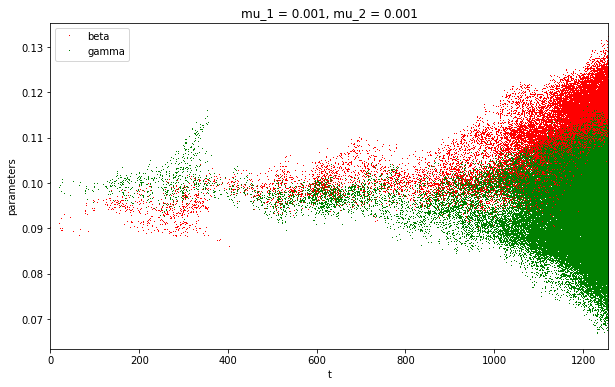

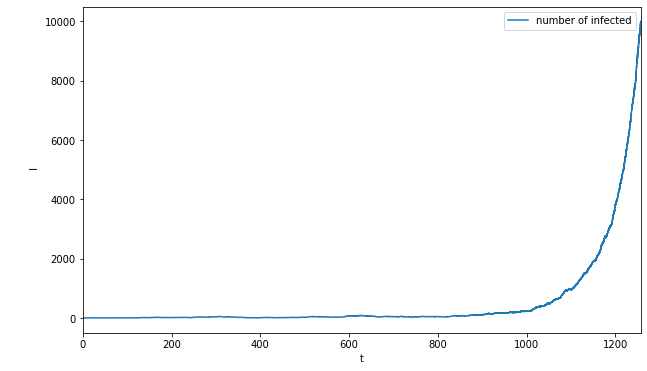

In [226]:
#plot betas and gammas over time
plt.figure(figsize=(10,6))
plt.plot(times, betas, ",r", label='beta')
plt.plot(times, gammas, ",g", label='gamma')
plt.title('mu_1 = {}, mu_2 = {}'.format(mu_1, mu_2))
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(loc="upper left")
plt.show()

#plot I over time
plt.figure(figsize=(10,6))
plt.plot(times, I, label='number of infected')
plt.xlabel("t"); plt.ylabel("\n \n I")
plt.autoscale(enable=True, axis='x', tight=True)
#plt.ylim(0, 1000)
plt.legend(loc="upper right")
plt.show()